In [2]:
import pandas as pd
import duckdb as db
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

In [3]:
con = db.connect("../../ingestao_de_dados/database/db_distribuicao_profissoes.db")

In [4]:
con.execute("SHOW TABLES").df()

,name
0,tbl_advogados_brasil_2024
1,tbl_contadores_brasil_2024
2,tbl_engenheiros_brasil_2024
3,tbl_estados_brasil
4,tbl_psicologos_brasil_2024


In [5]:
tabelas = {
    "advogados": "tbl_advogados_brasil_2024",
    "contadores": "tbl_contadores_brasil_2024",
    "engenheiros": "tbl_engenheiros_brasil_2024",
    "psicologos": "tbl_psicologos_brasil_2024",
    "estados": "tbl_estados_brasil"
}

tabela = {nome: con.execute(f"SELECT * FROM {tabela}").df() for nome, tabela in tabelas.items()}

In [86]:
tabela['advogados'].head()

,estado,feminino,masculino
0,AC,1898,2078
1,AL,7376,7847
2,AM,8181,7544
3,AP,2124,2049
4,BA,33281,28654


In [85]:
tabela['contadores'].head()

,estado,feminino,masculino
0,DF,6407,4512
1,GO,6276,4137
2,MS,2886,2637
3,MT,4241,4037
4,AL,1832,1433


In [84]:
tabela['engenheiros'].head()

,estado,feminino,masculino
0,CREA-AC,710,1892
1,CREA-AL,1677,7159
2,CREA-AM,4236,11833
3,CREA-AP,391,1278
4,CREA-BA,12202,39436


In [83]:
tabela['psicologos'].head()

,estado,feminino,masculino
0,Acre,1181,236
1,Alagoas,5399,991
2,Amapá,1201,261
3,Amazonas,5163,996
4,Bahia,21113,3559


In [82]:
tabela['estados'].head()

,id,uf,nome_estado
0,1,AC,Acre
1,2,AL,Alagoas
2,4,AM,Amazonas
3,5,AP,Amapá
4,6,BA,Bahia


In [11]:
con.execute("DESCRIBE tbl_advogados_brasil_2024").df()
con.execute("DESCRIBE tbl_contadores_brasil_2024").df()
con.execute("DESCRIBE tbl_engenheiros_brasil_2024").df()
con.execute("DESCRIBE tbl_psicologos_brasil_2024").df()

,column_name,column_type,null,key,default,extra
0,estado,VARCHAR,NO,PRI,None,None
1,feminino,INTEGER,YES,None,None,None
2,masculino,INTEGER,YES,None,None,None


In [12]:
query = """
    SELECT *, 'advogado' AS profissao
    FROM tbl_advogados_brasil_2024

    UNION ALL

    SELECT *, 'contador' AS profissao
    FROM tbl_contadores_brasil_2024

    UNION ALL

    SELECT *, 'engenheiro' AS profissao
    FROM tbl_engenheiros_brasil_2024

    UNION ALL

    SELECT *, 'psicologo' AS profissao
    FROM tbl_psicologos_brasil_2024
"""

In [13]:
df_profissoes = con.execute(query).df()
df_profissoes

,estado,feminino,masculino,profissao
0,AC,1898,2078,advogado
1,AL,7376,7847,advogado
2,AM,8181,7544,advogado
3,AP,2124,2049,advogado
4,BA,33281,28654,advogado
...,...,...,...,...
103,Roraima,971,167,psicologo
104,Santa Catarina,17963,2739,psicologo
105,São Paulo,132077,22613,psicologo
106,Sergipe,3372,723,psicologo


In [14]:
df_profissoes[df_profissoes['profissao'] == 'advogado'].describe()

,feminino,masculino
count,27.000000,27.000000
mean,27508.518519,25522.851852
std,39997.618600,36525.059606
min,1473.000000,1398.000000
25%,7741.000000,7695.500000
50%,13516.000000,12059.000000
75%,27792.500000,25293.500000
max,197236.000000,181116.000000


In [15]:
df_profissoes[df_profissoes['profissao'] == 'contador'].describe()

,feminino,masculino
count,27.000000,27.000000
mean,7631.000000,6777.518519
std,11128.348709,9851.721413
min,501.000000,512.000000
25%,2207.000000,1976.000000
50%,4174.000000,4037.000000
75%,7952.000000,6521.000000
max,56528.000000,49302.000000


In [16]:
df_profissoes[df_profissoes['profissao'] == 'engenheiro'].describe()

,feminino,masculino
count,27.000000,27.000000
mean,8695.222222,34465.666667
std,11525.265271,56973.482517
min,391.000000,1119.000000
25%,2029.000000,7572.000000
50%,4602.000000,17778.000000
75%,10007.500000,33231.500000
max,53124.000000,281812.000000


In [17]:
df_profissoes[df_profissoes['profissao'] == 'psicologo'].describe()

,feminino,masculino
count,27.000000,27.000000
mean,16698.592593,2884.222222
std,26513.606301,4540.061041
min,971.000000,167.000000
25%,4584.000000,756.000000
50%,6371.000000,1206.000000
75%,17526.500000,2834.500000
max,132077.000000,22613.000000


In [19]:
df_estados_profissoes = con.execute("""
    SELECT
        a.id,
        a.nome_estado,
        b.M_advogados,
        b.F_advogados,
        c.M_contadores,
        c.F_contadores,
        d.M_engenheiros,
        d.F_engenheiros,
        e.M_psicologos,
        e.F_psicologos
    
    FROM tbl_estados_brasil AS a 
    
    LEFT JOIN(
        SELECT 
            UPPER(estado) AS estado,
            masculino AS M_advogados,
            feminino AS F_advogados
        FROM tbl_advogados_brasil_2024        
    ) AS b ON UPPER(a.uf) = b.estado

    LEFT JOIN(
        SELECT 
            UPPER(estado) AS estado,
            masculino AS M_contadores,
            feminino AS F_contadores
        FROM tbl_contadores_brasil_2024
    ) AS c ON UPPER(a.uf) = c.estado

    LEFT JOIN(
        SELECT 
            UPPER(REPLACE(estado, 'CREA-', '')) AS estado,
            masculino AS M_engenheiros,
            feminino AS F_engenheiros
        FROM tbl_engenheiros_brasil_2024
    ) AS d ON UPPER(a.uf) = d.estado

    LEFT JOIN(
        SELECT 
            UPPER(estado) AS estado,
            masculino AS M_psicologos,
            feminino AS F_psicologos
        FROM tbl_psicologos_brasil_2024
    ) AS e ON UPPER(a.nome_estado) = e.estado
""").df()

In [20]:
df_estados_profissoes

,id,nome_estado,M_advogados,F_advogados,M_contadores,F_contadores,M_engenheiros,F_engenheiros,M_psicologos,F_psicologos
0,1,Acre,2078,1898,512,539,1892,710,236,1181
1,2,Alagoas,7847,7376,1433,1832,7159,1677,991,5399
2,4,Amazonas,7544,8181,3106,2532,11833,4236,996,5163
3,5,Amapá,2049,2124,660,743,1278,391,261,1201
4,6,Bahia,28654,33281,7314,9497,39436,12202,3559,21113
5,7,Ceará,20292,19541,4375,5587,19166,4673,2508,12387
6,8,Distrito Federal,25358,26508,4512,6407,18081,4602,2407,13246
7,9,Espírito Santo,13009,14451,4174,4174,17778,6004,1499,7601
8,10,Goiás,25229,28562,4137,6276,28991,8487,1966,13638
9,11,Maranhão,12020,12026,2475,3425,12044,3821,1028,5475


In [104]:
def contar_profissionais(genero_m,genero_f, profissao):    
    total_profissionais = con.execute(f"""
            SELECT nome_estado, ({genero_m.upper()}_{profissao} + {genero_f.upper()}_{profissao}) AS total_{profissao}
            FROM df_estados_profissoes
            ORDER BY total_{profissao} DESC
            LIMIT 5
        """).df()
    return total_profissionais

In [105]:
advogados = contar_profissionais('M', 'F', 'advogados')
contadores = contar_profissionais('M', 'F', 'contadores')
engenheiros = contar_profissionais('M', 'F', 'engenheiros')
psicologos = contar_profissionais('M', 'F', 'psicologos')

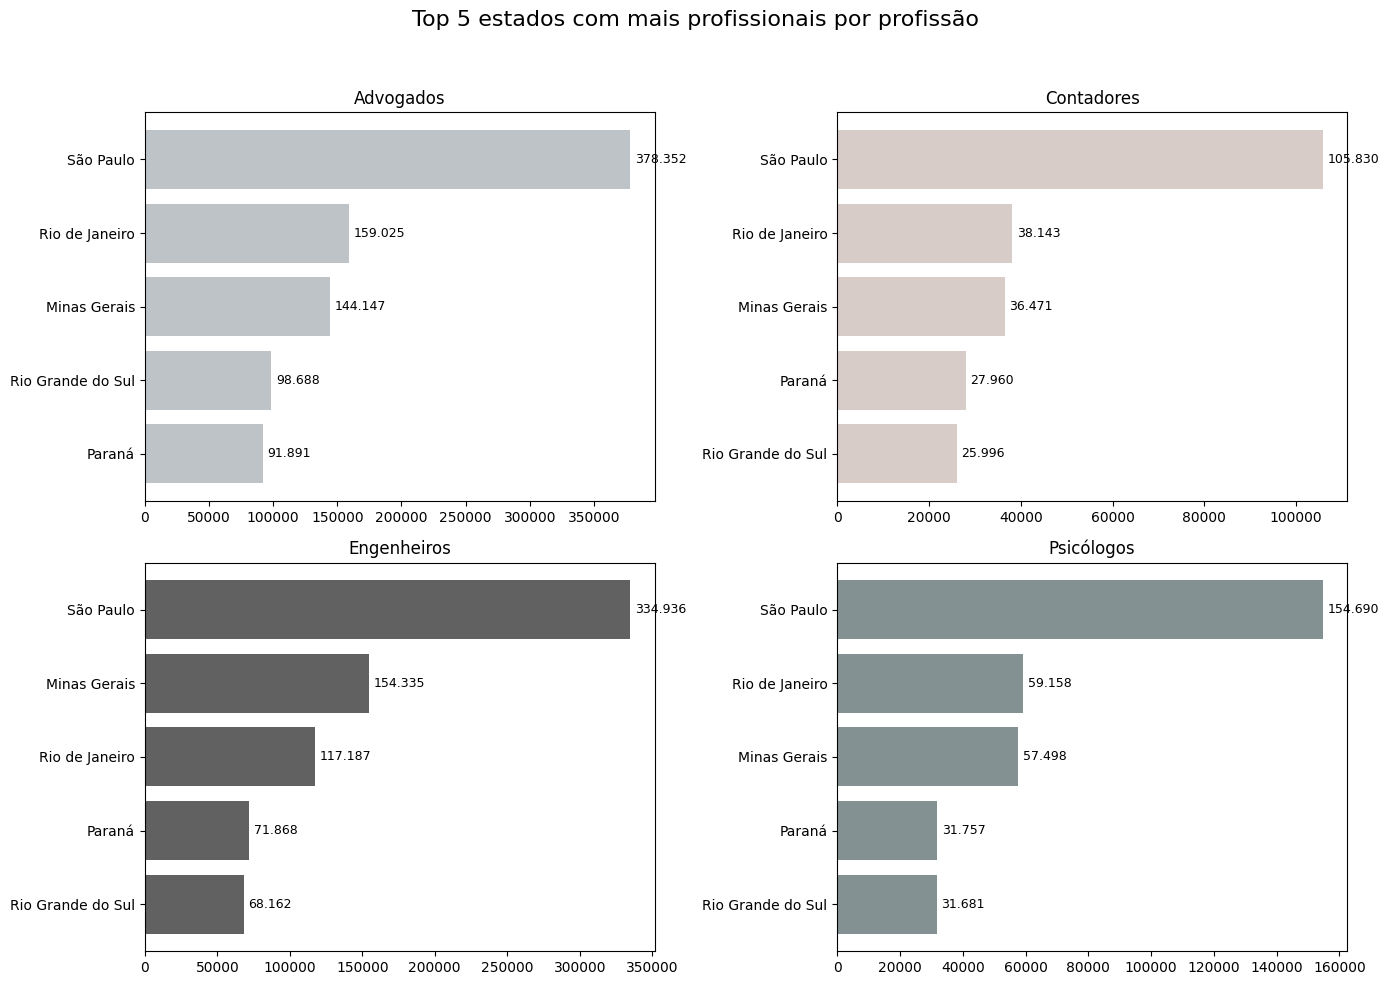

In [106]:
# Cria os subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Top 5 estados com mais profissionais por profissão', fontsize=16)

# Lista de dados, títulos e cores
dados = [
    (advogados, 'total_advogados', 'Advogados', '#bdc3c7'),
    (contadores, 'total_contadores', 'Contadores', '#d7ccc8'),
    (engenheiros, 'total_engenheiros', 'Engenheiros', '#616161'),
    (psicologos, 'total_psicologos', 'Psicólogos', '#839192')
]

# Geração dos gráficos com rótulos
for ax, (df, coluna, titulo, cor) in zip(axs.flat, dados):
    ax.barh(df['nome_estado'], df[coluna], color=cor)
    ax.set_title(titulo)
    ax.invert_yaxis()
    
    for i, v in enumerate(df[coluna]):
        ax.text(v + max(df[coluna]) * 0.01, i, f'{int(v):,}'.replace(',', '.'), va='center', fontsize=9)

# Ajusta layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [29]:
top5_masculino = con.execute("""
    SELECT 
        nome_estado,
        SUM(M_advogados) AS advogados,
        SUM(M_contadores) AS contadores,
        SUM(M_engenheiros) AS engenheiros,
        SUM(M_psicologos) AS psicologos,
        SUM(M_advogados + M_contadores + M_engenheiros + M_psicologos) AS total_masculino
    FROM df_estados_profissoes
    GROUP BY nome_estado
    ORDER BY total_masculino DESC
    LIMIT 5
""").df()

In [109]:
def distribuir_profissao_por_genero(genero, total_genero, nomes_femininos=False):
    if nomes_femininos:
        nomes_colunas = {
            'advogados': 'advogadas',
            'contadores': 'contadoras',
            'engenheiros': 'engenheiras',
            'psicologos': 'psicologas'
        }
    else:
        nomes_colunas = {
            'advogados': 'advogados',
            'contadores': 'contadores',
            'engenheiros': 'engenheiros',
            'psicologos': 'psicologos'
        }

    query = f"""
        SELECT 
            nome_estado,
            SUM({genero.upper()}_advogados) AS {nomes_colunas['advogados']},
            SUM({genero.upper()}_contadores) AS {nomes_colunas['contadores']},
            SUM({genero.upper()}_engenheiros) AS {nomes_colunas['engenheiros']},
            SUM({genero.upper()}_psicologos) AS {nomes_colunas['psicologos']},
            SUM({genero.upper()}_advogados + {genero.upper()}_contadores + {genero.upper()}_engenheiros + {genero.upper()}_psicologos) AS {total_genero}
        FROM df_estados_profissoes
        GROUP BY nome_estado
        ORDER BY {total_genero} DESC
        LIMIT 5
    """
    return con.execute(query).df()

In [116]:
maiores_estados_masculino = distribuir_profissao_por_genero('M', 'total_masculino', nomes_femininos=False)
maiores_estados_masculino

,nome_estado,advogados,contadores,engenheiros,psicologos,total_masculino
0,São Paulo,181116.0,49302.0,281812.0,22613.0,534843.0
1,Minas Gerais,69942.0,18568.0,121679.0,9033.0,219222.0
2,Rio de Janeiro,74423.0,17855.0,93569.0,8476.0,194323.0
3,Paraná,44869.0,12027.0,58273.0,4695.0,119864.0
4,Rio Grande do Sul,47028.0,13618.0,54101.0,4001.0,118748.0


In [117]:
maiores_estados_feminino = distribuir_profissao_por_genero('M', 'total_feminino', nomes_femininos=True)
maiores_estados_feminino

,nome_estado,advogadas,contadoras,engenheiras,psicologas,total_feminino
0,São Paulo,181116.0,49302.0,281812.0,22613.0,534843.0
1,Minas Gerais,69942.0,18568.0,121679.0,9033.0,219222.0
2,Rio de Janeiro,74423.0,17855.0,93569.0,8476.0,194323.0
3,Paraná,44869.0,12027.0,58273.0,4695.0,119864.0
4,Rio Grande do Sul,47028.0,13618.0,54101.0,4001.0,118748.0


In [112]:
def plotar_distribuicao_genero(df, profissoes, titulo, cor_legenda, genero_label):
    estados = df['nome_estado'].tolist()
    valores = [df[prof].values for prof in profissoes]
    
    x = np.arange(len(estados))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (label, cor) in enumerate(zip(profissoes, cor_legenda)):
        bars = ax.bar(x + i * width, valores[i], width, label=label.capitalize(), color=cor)
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height):,}'.replace(',', '.'),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    ax.set_ylabel(f'Quantidade de profissionais ({genero_label})')
    ax.set_title(titulo)
    ax.set_xticks(x + width * (len(profissoes) - 1) / 2)
    ax.set_xticklabels(estados)
    ax.legend()
    plt.tight_layout()
    plt.show()

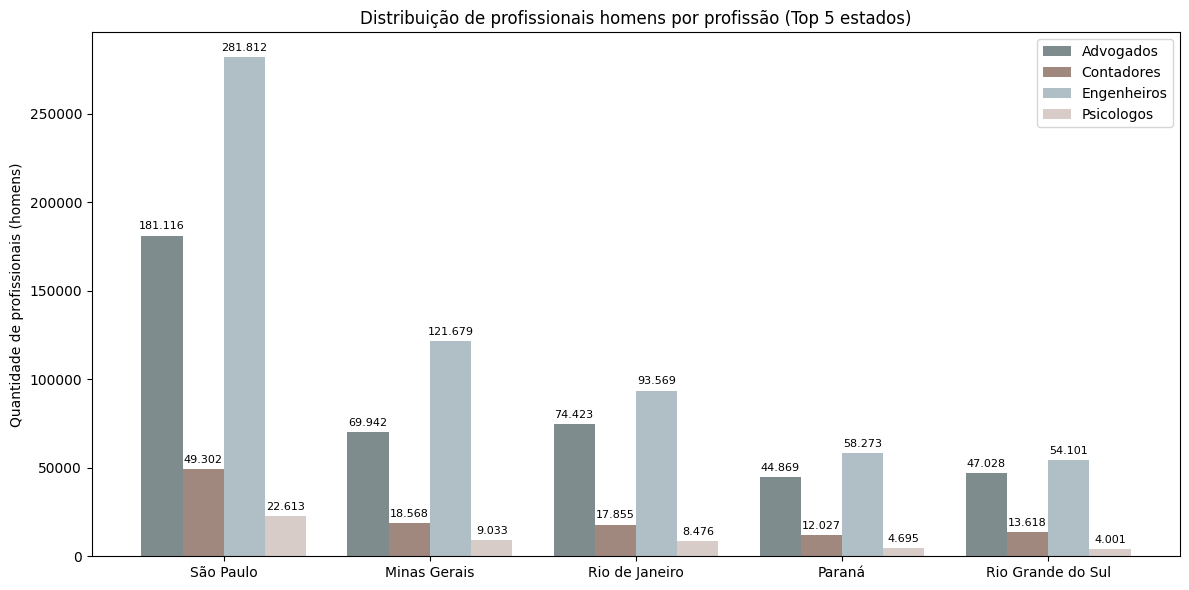

In [118]:
plotar_distribuicao_genero(
    df=maiores_estados_masculino,
    profissoes=['advogados', 'contadores', 'engenheiros', 'psicologos'],
    titulo='Distribuição de profissionais homens por profissão (Top 5 estados)',
    cor_legenda=['#7f8c8d', '#a1887f', '#b0bec5', '#d7ccc8'],
    genero_label='homens'
)

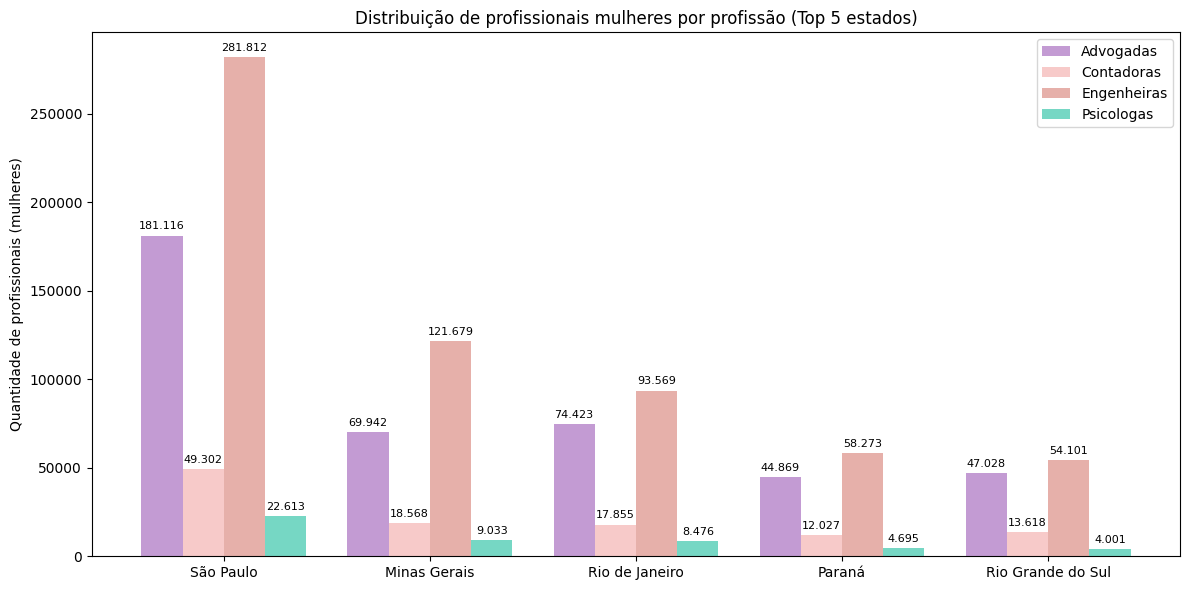

In [119]:
plotar_distribuicao_genero(
    df=maiores_estados_feminino,
    profissoes=['advogadas', 'contadoras', 'engenheiras', 'psicologas'],
    titulo='Distribuição de profissionais mulheres por profissão (Top 5 estados)',
    cor_legenda=['#c39bd3', '#f7cac9', '#e6b0aa', '#76d7c4'],
    genero_label='mulheres'
)

In [79]:
# Função para gerar gráfico horizontal com rótulos
def plot_top5_profissao(df, coluna_valor, titulo, cor):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(df['nome_estado'], df[coluna_valor], color=cor)
    ax.set_xlabel('Número de profissionais')
    ax.set_title(titulo)

    for i, v in enumerate(df[coluna_valor]):
        ax.text(v + max(df[coluna_valor])*0.01, i, str(v), va='center', fontsize=10)

    ax.invert_yaxis()  # Coloca o maior valor no topo
    plt.tight_layout()
    plt.show()

In [90]:
def ordena_query_profissão(genero, profissao):
	profissao_genero = con.execute(f"""
		SELECT nome_estado, {genero}_{profissao} AS total
		FROM df_estados_profissoes
		ORDER BY total DESC
		LIMIT 5
		""").df()
	return profissao_genero

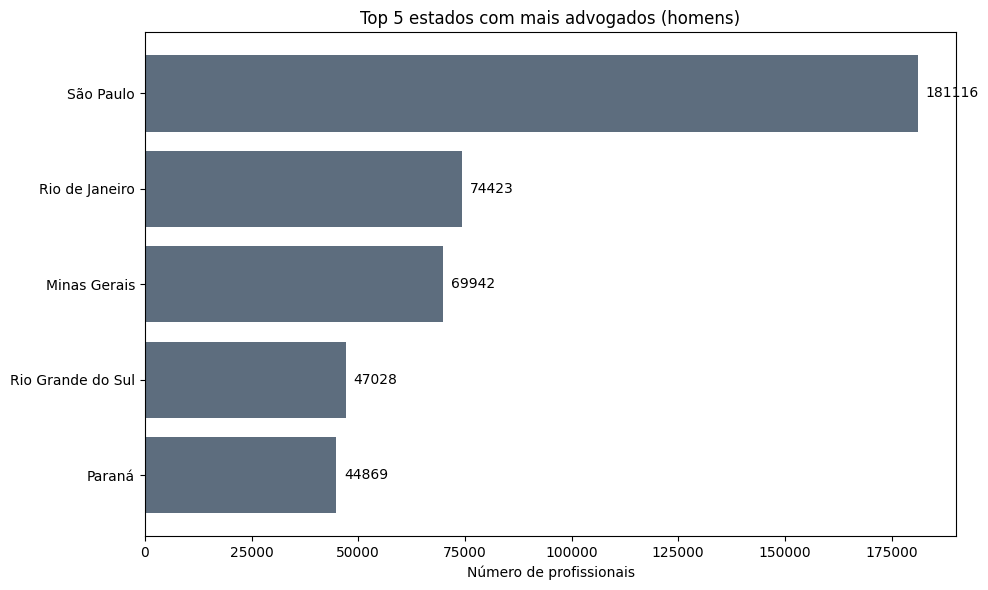

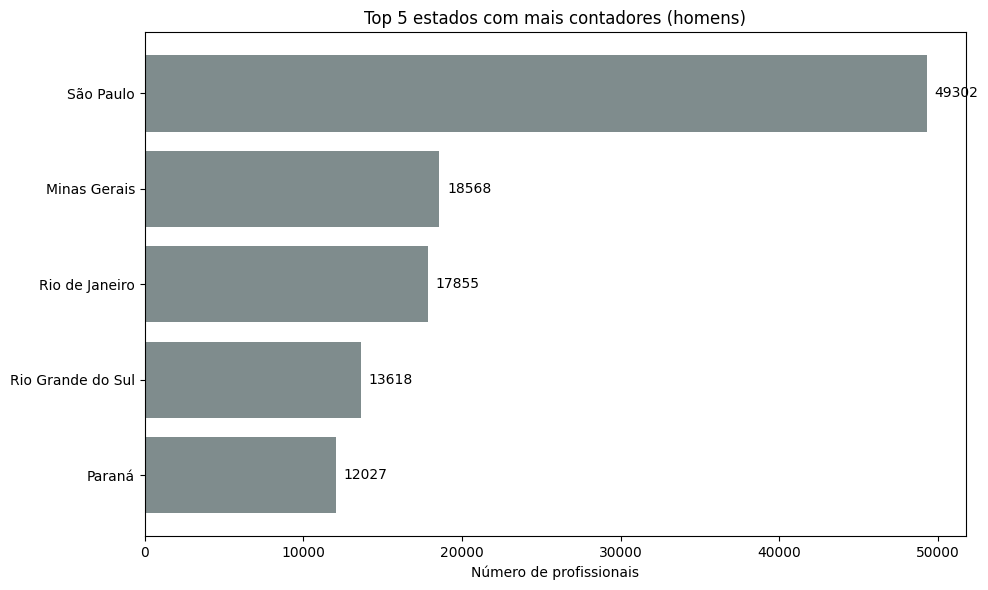

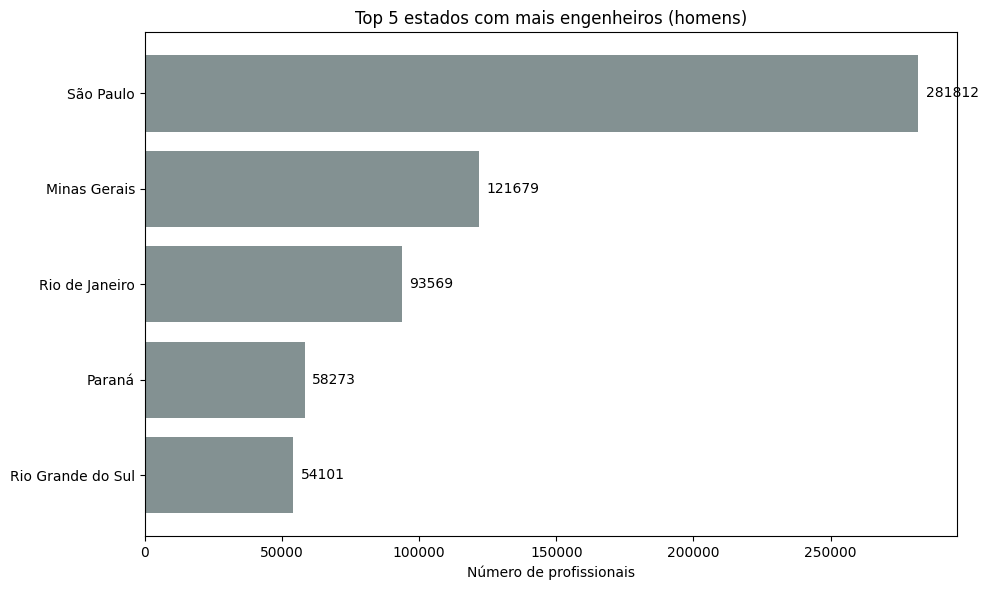

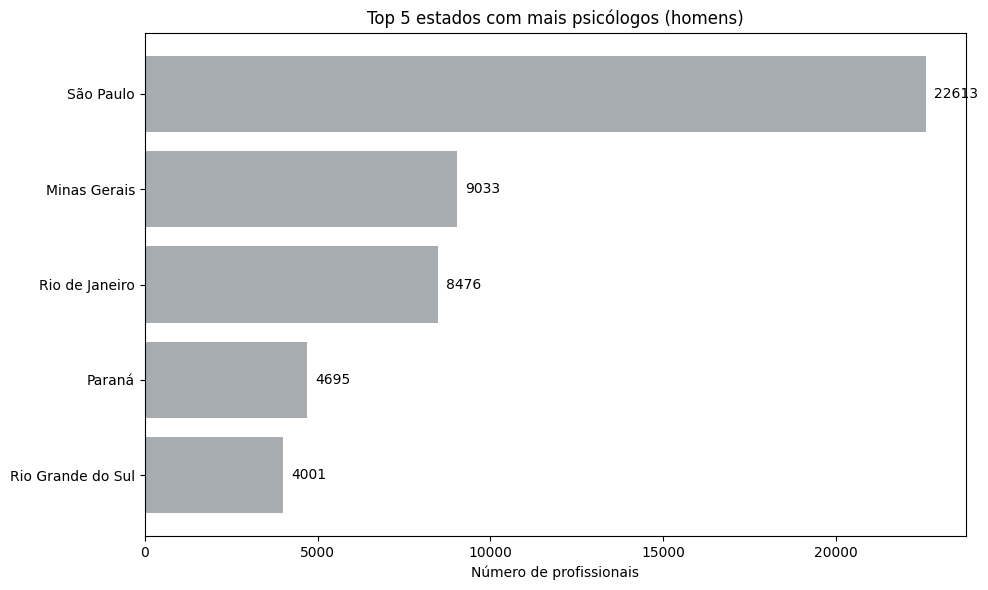

In [91]:
plot_top5_profissao(ordena_query_profissão('M', 'advogados'), 'total', 'Top 5 estados com mais advogados (homens)', '#5d6d7e')
plot_top5_profissao(ordena_query_profissão('M', 'contadores'), 'total', 'Top 5 estados com mais contadores (homens)', '#7f8c8d')
plot_top5_profissao(ordena_query_profissão('M', 'engenheiros'), 'total', 'Top 5 estados com mais engenheiros (homens)', '#839192')
plot_top5_profissao(ordena_query_profissão('M', 'psicologos'), 'total', 'Top 5 estados com mais psicólogos (homens)', '#a6acaf')

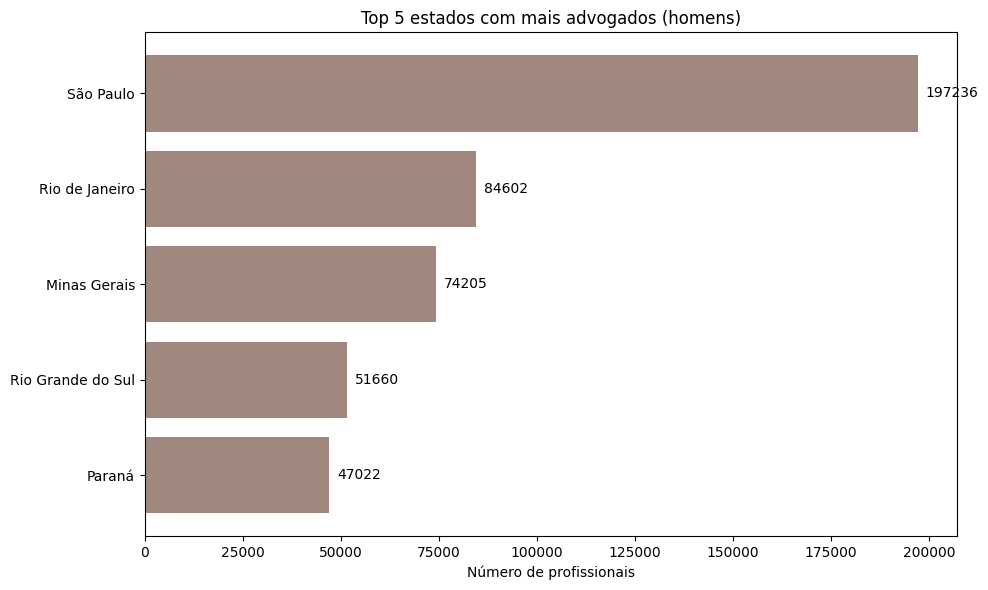

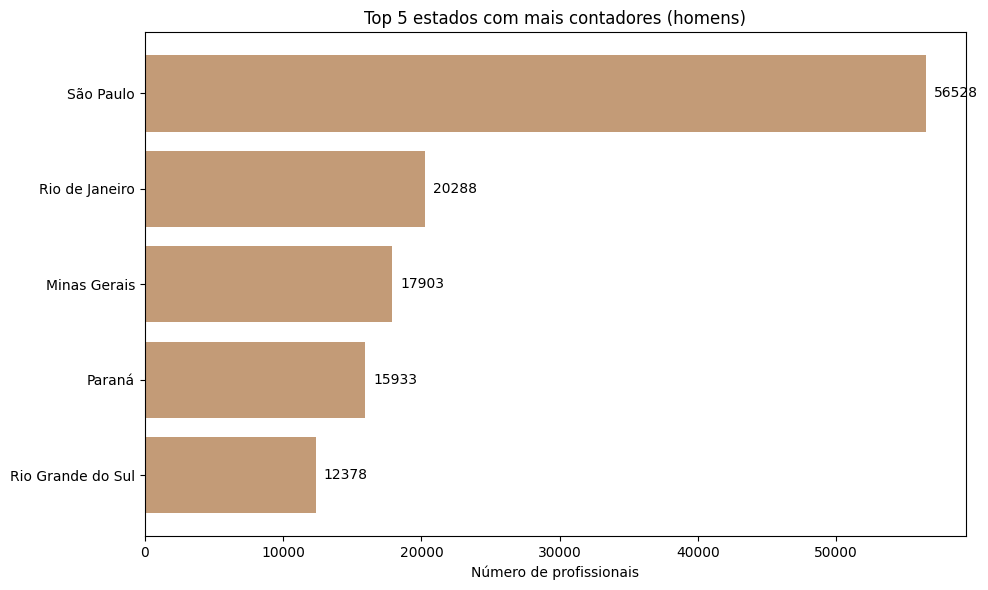

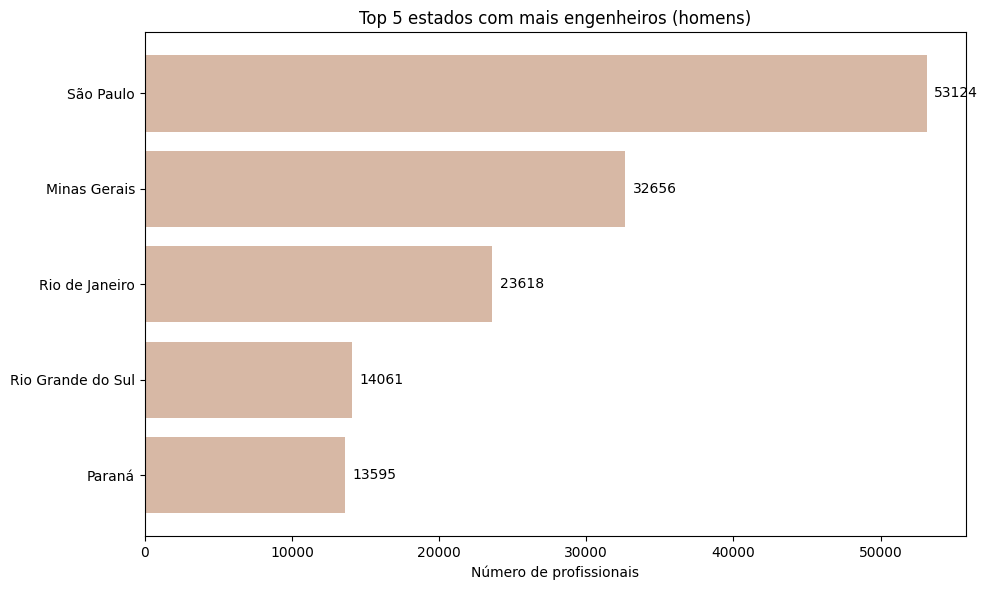

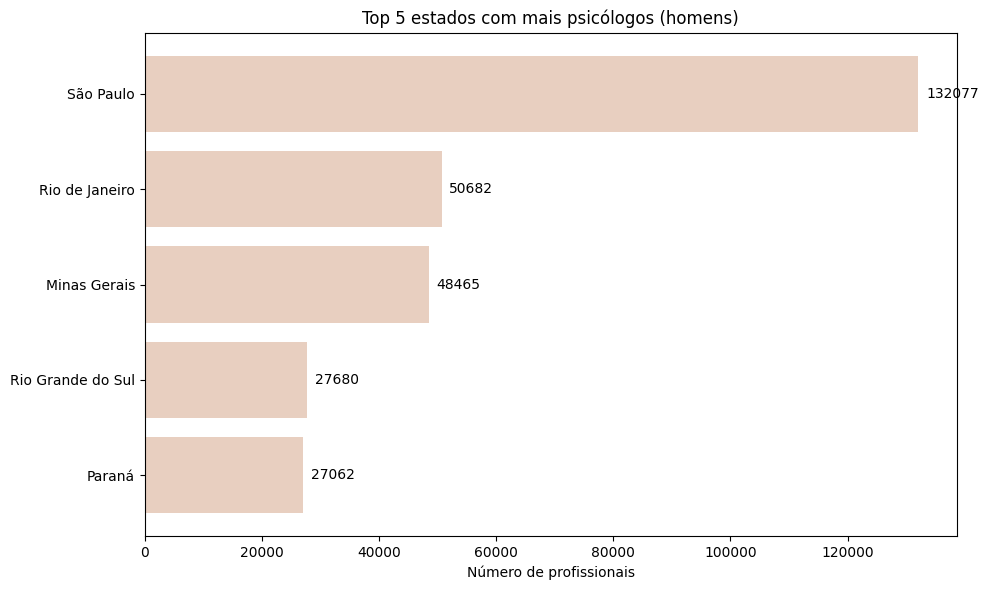

In [93]:
plot_top5_profissao(ordena_query_profissão('F', 'advogados'), 'total', 'Top 5 estados com mais advogados (homens)', '#a1887f')
plot_top5_profissao(ordena_query_profissão('F', 'contadores'), 'total', 'Top 5 estados com mais contadores (homens)', '#c39b77')
plot_top5_profissao(ordena_query_profissão('F', 'engenheiros'), 'total', 'Top 5 estados com mais engenheiros (homens)', '#d7b8a5')
plot_top5_profissao(ordena_query_profissão('F', 'psicologos'), 'total', 'Top 5 estados com mais psicólogos (homens)', '#e8cfc0')